In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

C:\Users\lolis\AppData\Local\Temp\ipykernel_13248\3884926229.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:


def avg_metric(df: pd.DataFrame, metric_name: str):
    all_data = None
    nb_point = 0
    # Iterate through the columns of the DataFrame
    for metric in df.columns[1:]:  # Skip the first column which is typically 'Time' or 'Delta'
        if metric_name in metric:
            nb_point += 1
            if all_data is None:
                all_data = df[metric].copy()
            else:
                all_data += df[metric]
    
    # If no matching metrics were found, return an empty Series
    if nb_point == 0:
        return pd.Series([0] * len(df))
    
    # Calculate the average
    return all_data / nb_point
    return all_data/nb_point


def generate_aggregated_power_charts_comparison(csv_files):
    # Check if all CSV files exist
    for csv_file in csv_files:
        if not os.path.exists(csv_file):
            raise ValueError(f'{csv_file} does not exist')

    power_aggregates = []  # This will hold aggregated power values for each file
    labels = []  # This will store the file names for the legend
    
    # Iterate over each CSV file to calculate power aggregates
    for csv_file in csv_files:
        power_aggregate = []  # To store aggregated power for this file
        df = pd.read_csv(csv_file)
        deltatime = 0.2  # 200ms for each measurement (default)
        
        # Determine which key to use based on available columns
        key = "PACKAGE_ENERGY (W)"  # Default key
        if "CPU_ENERGY (J)" in df.columns:
            key = "CPU_ENERGY (J)"
        elif "PACKAGE_ENERGY (J)" in df.columns:
            key = "PACKAGE_ENERGY (J)"
        elif "SYSTEM_POWER (Watts)" in df.columns:
            key = "SYSTEM_POWER (Watts)"
        
        data = df[key].copy().to_list()

        # Calculate aggregated power if needed
        if key != "CPU_POWER (Watts)" and key != "SYSTEM_POWER (Watts)":
            df[key + "_original"] = df[key].copy()
            for i in range(0, len(data)):
                if i > 0:
                    # Diff with previous value and convert to watts
                    data[i] = (data[i] - df[key + "_original"][i - 1]) * (1000 / df["Delta"][i])
                else:
                    data[i] = 0

                # Aggregating power (cumulative sum of the converted data)
                if i == 0:
                    power_aggregate.append(0)
                else:
                    power_aggregate.append(data[i] / 5 + power_aggregate[i - 1])

        # Append the aggregated power data for this file
        power_aggregates.append(power_aggregate)
        labels.append(os.path.basename(csv_file))  # Store the file name for the legend

    # Plot all aggregated power data
    plt.figure(figsize=(10, 6))
    
    # Generate x-axis based on the deltatime (time between measurements)
    for i, power_aggregate in enumerate(power_aggregates):
        x_axis = [deltatime * i for i in range(len(power_aggregate))]  # Adjusted x-axis
        
        # Plot each aggregated power with a unique color and label
        plt.plot(x_axis, power_aggregate, label=labels[i])

    # Set the plot labels and title
    plt.xlabel("Time (seconds)")
    plt.ylabel("Aggregated Power (Joules)")
    plt.title("Aggregated Power Comparison Across CSV Files")
    
    # Add the legend to the plot
    plt.legend(loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.savefig("power_comparison.png")  # Save as PNG file
    plt.show()
        

def generate_metric_charts(csv_file):
    power_aggregated = []
    all_data = []
    if not os.path.exists(csv_file):
        raise ValueError(f'{csv_file} does not exist')
    df = pd.read_csv(csv_file)
    key = "PACKAGE_ENERGY (W)"
    if "CPU_ENERGY (J)" in df.columns:
        key = "CPU_ENERGY (J)"
    if "PACKAGE_ENERGY (J)" in df.columns:
        key = "PACKAGE_ENERGY (J)"
    if "SYSTEM_POWER (Watts)" in df.columns:
        key = "SYSTEM_POWER (Watts)"
    data = df[key].copy().to_list()
    if key != "CPU_POWER (Watts)" and key != "SYSTEM_POWER (Watts)":
        df[key + "_original"] = df[key].copy()
        for i in range(0, len(data)):
            if i in df[key + "_original"] and i - 1 in df[key + "_original"]:
                # diff with previous value and convert to watts
                data[i] = (data[i] - df[key + "_original"][i - 1]) * (1000 / df["Delta"][i])
            else:
                data[i] = 0
            if i == 0:
                power_aggregated.append(0)
            else:
                power_aggregated.append(data[i]/5 + power_aggregated[i-1])
    data = data[1:-1]
    for i in range(0, len(data)):
        all_data.append({"Time": i, "CPU_POWER (Watts)": data[i]})
    # Generate x_axis based on the average delta time
    x_axis = [i * 0.2 for i in range(len(data))]
    x_axis_2 = [i * 0.2 for i in range(len(data) + 2)]
    # Now plot everything using x_axis for consistent time scaling
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot CPU Power
    ax.plot(x_axis, data, label="CPU Power")
    ax.set_ylabel('Watts')

    # Create a second y-axis for the other metrics
    ax2 = ax.twinx()

    # Plot the average temperature, usage, and memory percentage using x_axis for consistent timing
    ax2.plot(x_axis_2, avg_metric(df, "CPU_TEMP"), label="CPU TEMP (C)", color="red")
    ax2.plot(x_axis_2, avg_metric(df, "CPU_USAGE"), label="CPU USAGE (%)", color="orange")
    ax2.plot(x_axis_2, df["USED_MEMORY"] * 100 / df["TOTAL_MEMORY"], label="Used Memory (%)", color="green")
    
    ax2.set_ylim([0, 100])

    # Set labels and legend
    ax.set(xlabel="Time (seconds)")
    fig.legend(loc='upper right')
    fig.tight_layout()

    # Show the aggregated power plot
    plt.tight_layout()
    plt.show()
    # Display the plot
    plt.show()


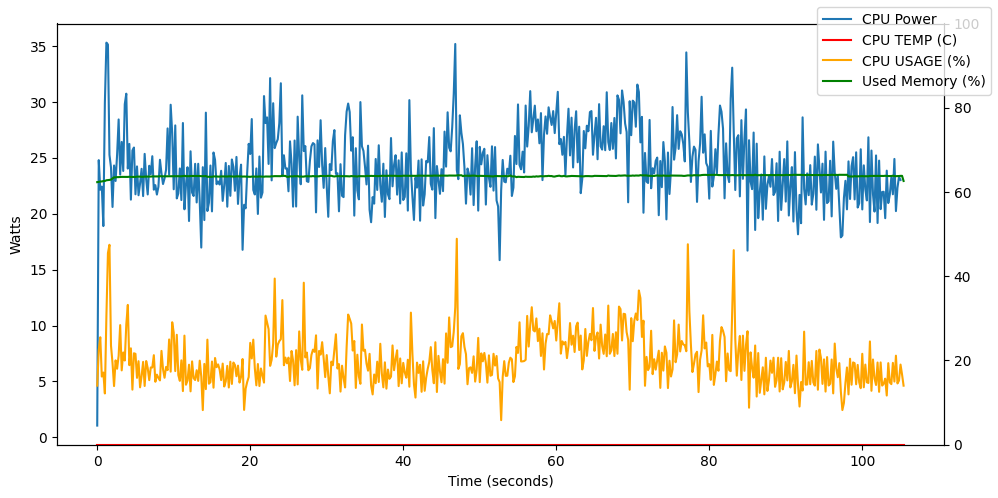

In [3]:
generate_metric_charts(os.path.join(os.getcwd(), 'result_jlink.csv'))

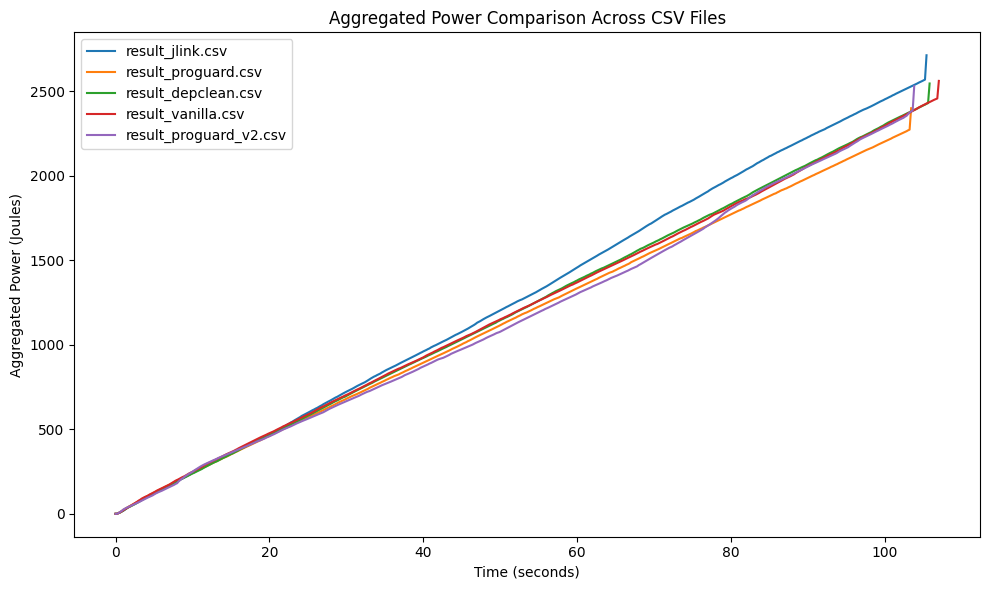

In [5]:
csv_files = ['result_jlink.csv','result_proguard.csv','result_depclean.csv','result_vanilla.csv','result_proguard_v2.csv']
generate_aggregated_power_charts_comparison(csv_files)